In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import keras
import keras.backend as K

Using TensorFlow backend.


In [22]:
train_df=pd.read_csv('train.csv',sep=',')

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [25]:
train_df.describe()

,teacher_number_of_previously_posted_projects,project_is_approved
count,182080.000000,182080.000000
mean,11.237055,0.847682
std,28.016086,0.359330
min,0.000000,0.000000
25%,0.000000,1.000000
50%,2.000000,1.000000
75%,9.000000,1.000000
max,451.000000,1.000000


In [3]:
train_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [4]:
print(train_df.shape)

(182080, 16)


In [5]:
train,dev=train_test_split(train_df,random_state=123,shuffle=True,test_size=0.1)

In [7]:
print("training data shape : ",train.shape)
print("test data shape : ",dev.shape)

training data shape :  (163872, 16)
test data shape :  (18208, 16)


In [12]:
%%time

def get_project_essay(df):
    return (df["project_essay_1"].fillna('') +
            ' ' + df["project_essay_2"].fillna('') +
            ' ' + df["project_essay_3"].fillna('') +
            ' ' + df["project_essay_4"].fillna(''))

def get_text(df):
    return df["project_title"].fillna('') + ' ' + get_project_essay(df)

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(get_text(train))

def preprocess_target(df):
    return df[["project_is_approved"]].copy()

def preprocess_data(df):
    processed_df = df[["teacher_number_of_previously_posted_projects"]].copy()
    processed_df["project_title"] = tokenizer.texts_to_sequences(df["project_title"])
    processed_df["project_essay"] = tokenizer.texts_to_sequences(get_project_essay(df))
    
    return processed_df

processed_train = preprocess_data(train)
y_train = preprocess_target(train)
print(processed_train.shape, y_train.shape)

processed_dev = preprocess_data(dev)
y_dev = preprocess_target(dev)
print(processed_dev.shape, y_dev.shape)

(163872, 3) (163872, 1)
(18208, 3) (18208, 1)
Wall time: 1min 9s


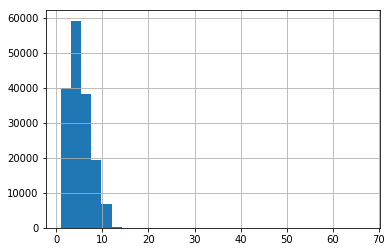

In [17]:
a=processed_train['project_title'].apply(lambda x:len(x))
a.hist(bins=30)

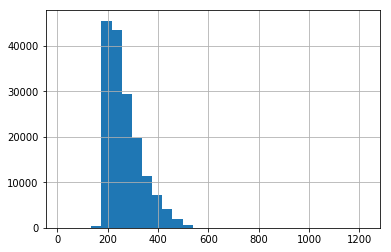

In [18]:
b=processed_train['project_essay'].apply(lambda x:len(x))
b.hist(bins=30)

In [19]:
MAX_PROJECT_TITLE_SEQ_LEN = 12
MAX_PROJECT_TITLE = processed_train["project_title"].apply(lambda x: max(x) if len(x) > 0 else 0).max() + 1

MAX_PROJECT_ESSAY_SEQ_LEN = 450
MAX_PROJECT_ESSAY = processed_train["project_essay"].apply(lambda x: max(x) if len(x) > 0 else 0).max() + 1

MAX_TEXT = max([MAX_PROJECT_TITLE, MAX_PROJECT_ESSAY])

def get_keras_data(df):
    return {
        "teacher_number_of_previously_posted_projects": np.array(df["teacher_number_of_previously_posted_projects"]),
        "project_title": keras.preprocessing.sequence.pad_sequences(df["project_title"], maxlen=MAX_PROJECT_TITLE_SEQ_LEN),
        "project_essay": keras.preprocessing.sequence.pad_sequences(df["project_essay"], maxlen=MAX_PROJECT_ESSAY_SEQ_LEN),
    }

X_train = get_keras_data(processed_train)
X_dev = get_keras_data(processed_dev)

#RNN Model

In [20]:
def create_rnn_model():
    # Input layers
    teacher_number_of_previously_posted_projects = keras.layers.Input(shape=(1,), name="teacher_number_of_previously_posted_projects")
    project_title = keras.layers.Input(shape=(MAX_PROJECT_TITLE_SEQ_LEN,), name="project_title")
    project_essay = keras.layers.Input(shape=(MAX_PROJECT_ESSAY_SEQ_LEN,), name="project_essay")
    
    
    
    emb_layer = keras.layers.Embedding(MAX_TEXT, 50)
    emb_project_title = emb_layer(project_title)
    emb_project_essay = emb_layer(project_essay)
    
    # RNN layers
    rnn_project_title = keras.layers.GRU(8, activation="relu")(emb_project_title)
    rnn_project_essay = keras.layers.GRU(16, activation="relu")(emb_project_essay)
    
    
    # Merge all layers into one
    x = keras.layers.concatenate([teacher_number_of_previously_posted_projects,
                                 rnn_project_title,
                                 rnn_project_essay,
                                 #rnn_project_resource_summary,
                                 ])
    
   

    # Output layers
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    
    return keras.models.Model(
        inputs=[teacher_number_of_previously_posted_projects,
                project_title,
                project_essay,
                #project_resource_summary,
               ],
        outputs=output)

rnn_model = create_rnn_model()
rnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
project_title (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
project_essay (InputLayer)      (None, 450)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             4132100     project_title[0][0]              
                                                                 project_essay[0][0]              
__________________________________________________________________________________________________
teacher_number_of_previously_po (None

In [21]:
optimizer = keras.optimizers.Adam(lr=0.001)
rnn_model.compile(optimizer=optimizer,
                  loss=keras.losses.binary_crossentropy,
                  metrics=["accuracy"])

for i in range(3):
    rnn_model.fit(X_train, y_train,
                 batch_size=(2 ** (i + 8)),
                 epochs=1,
                 validation_data=(X_dev, y_dev))

Instructions for updating:
Use tf.cast instead.
Train on 163872 samples, validate on 18208 samples
Epoch 1/1
163872/163872 [==============================] - 343s 2ms/step - loss: 0.9615 - acc: 0.7651 - val_loss: 0.4155 - val_acc: 0.8456
Train on 163872 samples, validate on 18208 samples
Epoch 1/1
163872/163872 [==============================] - 348s 2ms/step - loss: 0.3993 - acc: 0.8479 - val_loss: 0.4112 - val_acc: 0.8457
Train on 163872 samples, validate on 18208 samples
Epoch 1/1
163872/163872 [==============================] - 378s 2ms/step - loss: 0.3739 - acc: 0.8498 - val_loss: 0.3922 - val_acc: 0.8461


In [26]:
preds = rnn_model.predict(X_dev, batch_size=512)
auc_score = roc_auc_score(y_dev, preds)
print("AUC for validation data: %.4f" % (auc_score,))

AUC for validation data: 0.7247


Submission

In [28]:
test_df = pd.read_csv("test.csv", sep=',')

processed_test = preprocess_data(test_df)

X_test = get_keras_data(processed_test)

preds = rnn_model.predict(X_test, batch_size=512)

submission = pd.DataFrame({
    "id": test_df["id"],
    "project_is_approved": preds.reshape(-1),
})

submission.to_csv("submission.csv", index=False)


C:\Users\Tushar saini\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
